In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#SET PARAMETERS
cell_number = 4 #Can use the .des file to determine the identity of each cell number ~the first half if PFC cells
resolution = 2 #cm per plotted pixel, must be an int
    #Nardin et al., 2023 uses 5cm square bins
filepath = 'JC315-20240407/JC315-20240407_training1' #For .clu, .res, and .whl, but do not include the file endings

#Import .res and .clu
def to_int_list(filename):
    file = open(filename)
    file_list = file.readlines()
    file.close()
    for i in range(len(file_list)):
        file_list[i] = int(file_list[i].strip('\n'))
    return file_list

#.clu file is the cluster ID (putative neuron ID) for the corresponding .res file spikes
clu = to_int_list(filepath + '.clu')[1:]#Removing the first (noise) cluster
#.res file is the "frame" at sampling frequency 20kHz in which spikes occur
res = to_int_list(filepath + '.res')

#Import .whl
whl_raw = open(filepath + '.whl')
whl = whl_raw.readlines()
whl_raw.close()

for i in range(len(whl_unfiltered)):
    x_y = whl[i].split()
    whl[i] = [float(x_y[0]), float(x_y[1].strip('\n'))]

#Convert [1023, 1023] to NaN
for i, x in enumerate(whl):
    if x == [1023, 1023]:
        whl[i] = 'NaN'

In [45]:
#Determine the location of a rat at each spike of a cluster
spike_index = [i for i, x in enumerate(clu) if x == cell_number] #since clu and res have corresponding indices
num_spikes = len(spike_index)
spike_frame = [res[i] for i in spike_index]#in frame number of the spike recording, in 20kHz
pos_frame = [i / 512 for i in spike_frame]#Match spike frame numbers with position measurement

#Round down to the nearest integer and take that index of the .whl
# spike_positions = [whl[int(i // 1)] for i in pos_frame if whl[int(i // 1)] != [-1, -1]] #Excluding [-1, -1] values from the whl
spike_positions = [whl[int(i // 1)] for i in pos_frame] #Excluding [-1, -1] values from the whl

In [46]:
#Count spikes in each square of a grid
area = np.zeros((200//resolution, 200//resolution)) #The overall values are 200x200 cm

# spike_positions = [i for i in raw_spike_positions if 
for i in range(len(spike_positions)): 
    if spike_positions[i] != 'NaN':
        x = int(spike_positions[i][0]//resolution)
        y = int(spike_positions[i][1]//resolution)
        area[y, x] += 1 #Switch x and y since I want to graph as if cartesian coords, same with occupancy matrix below

#Determine occupancy in each square in seconds
occupancy = np.zeros((200//resolution, 200//resolution))

for value in whl:
    if value != 'NaN':
        x = int(value[0] // resolution)
        y = int(value[1] // resolution)
        # if x > np.size(occupancy)[0] or y > np.size(occupancy):
        #     print('x: ' + x + ' y: ' + y)
        occupancy[y, x] += 1 / 39.0625 #Occupancy values are now in seconds, x and y are flipped bc of python's row-first indexing
        
#Plot overall occupancy
# fig, ax = plt.subplots()
# ax = plt.gca() #get current axis
# plt.imshow(occupancy);
# ax.set_ylim(ax.get_ylim()[::-1]);

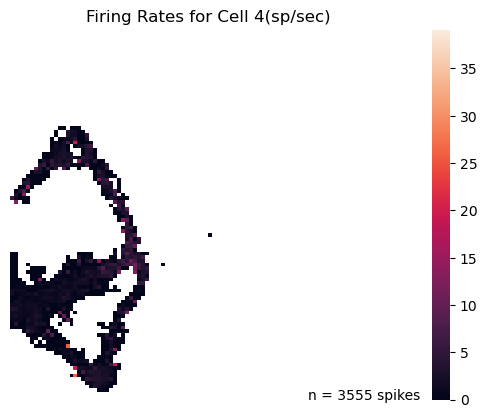

In [47]:
#Determine spikes per second spent in each square by dividing spike count by occupancy in seconds
sp_sec = np.zeros((200//resolution, 200//resolution))
for i in range(len(area)):
    for j in range(np.shape(area)[1]):
        if occupancy[i][j] == 0:
            sp_sec[i, j] = 'nan'
        else:
            sp_sec[i, j] = area[i][j] / occupancy[i][j]

fig, ax = plt.subplots()
ax = sns.heatmap(sp_sec)
ax.invert_yaxis()
plt.xticks([]);
plt.yticks([]);
plt.title('Firing Rates for Cell ' + str(cell_number) + '(sp/sec)')
ax.annotate('n = ' + str(num_spikes) + ' spikes', xy=(150//resolution, 0));

In [48]:
#Determine the highest firing rate and where this occurs
max_rate = max(sp_sec[~np.isnan(sp_sec)]) #To exclude nan values in finding the max
    
if len(np.where(sp_sec == max_rate)) != 2:
    raise Exeption('tied for max firing rate, len = ', len(np.where(sp_sec == max_rate)))

max_location = [int(i[0]) for i in np.where(sp_sec == max_rate)] #But x and y are flipped as with the input
    #np.where will return a tuple of arrays, this converts to a list
print(f"Max firing rate of {max_rate:.4f}sp/sec at x:{max_location[1] * resolution}cm, y:{max_location[0] * resolution}cm")

Max firing rate of 39.0625sp/sec at x:68cm, y:74cm


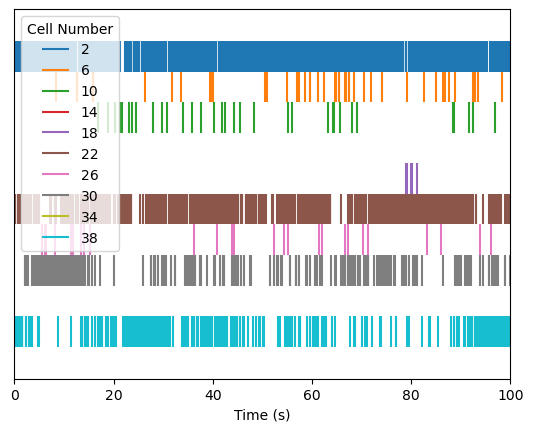

In [49]:
#Plot multiple cell raster plots together
cell_numbers = range(40)[2:40:4] #Or specify cells to graph, but I don't think nrn 1 exists

raster_spikes = []

for cell_number in cell_numbers:
    spike_index = [i for i, x in enumerate(clu) if x == cell_number] #since clu and res have corresponding indices
    num_spikes = len(spike_index)
    spike_frame = [res[i] for i in spike_index]#in frame number of the spike recording, in 20kHz
    pos_frame = [i / 512 for i in spike_frame]#Match spike frame numbers with position measurement
    time_stamps = [i/39.0625 for i in pos_frame] #And the max time stamp is 30.5 min which seems correct
    raster_spikes.append(time_stamps)

fig, ax = plt.subplots()
colors1 = [f'C{i}' for i in range(len(cell_numbers))]
ax.eventplot(raster_spikes, colors = colors1)
ax.invert_yaxis()
plt.yticks([]);
plt.xlabel("Time (s)")
plt.xlim(0, 100)
plt.legend(cell_numbers, loc='upper left', title='Cell Number');
# plt.title('Spikes');

'''OR make a raster plot just for the cell specified at the top
#Make a raster plot of the selected cell – for the first 100 seconds to see better

#pos_frame is spike times in terms of position frames
time_stamps = [i/39.0625 for i in pos_frame] #And the max time stamp is 30.5 min which seems correct
fig, ax = plt.subplots()
ax.eventplot(time_stamps)
plt.yticks([]);
plt.xlabel("Time (s)")
plt.xlim(0, 100)
plt.title('Cell ' + str(cell_number) + ' Spikes');''';